In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LeakyReLU, Input, concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1_l2
from keras.backend import clear_session
from livelossplot import PlotLossesKeras

from glob import glob
from os.path import join

from scipy.stats import zscore
from functools import reduce

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
weather_path = join('..','data','weather','precip_temp.csv')
weather_df = pd.read_csv(weather_path)
clients_path = join('..','data','wifi','**','Clients per day.csv')
clients_df = pd.concat(map(lambda csv: pd.read_csv(csv, parse_dates=[0]),
                sorted(glob(clients_path),reverse=True)), ignore_index=True)
sessions_path = join('..','data','wifi','**','Number of sessions over time.csv')
sessions_df = pd.concat(map(lambda csv: pd.read_csv(csv, parse_dates=[0]),
                sorted(glob(sessions_path), reverse=True)), ignore_index=True)
usage_path = join('..','data','wifi','**','Usage over time.csv')
usage_df = pd.concat(map(lambda csv: pd.read_csv(csv, parse_dates=[0]),
                sorted(glob(usage_path), reverse=True)), ignore_index=True)
# Interpolate zeros in usage and sessions data
#usage_df.loc[usage_df['Total (B)'] == 0, 'Total (B)'] = np.NaN
#usage_df['Total (B)'] = usage_df['Total (B)'].interpolate()
# Remove implausibly small values
usage_df['filtered Total (B)'] = usage_df['Total (B)']
#print (usage_df['filtered Total (B)'].values)
#usage_df.loc[usage_df['filtered Total (B)'] < 1000, 'filtered Total (B)'] = 1000
#usage_df['filtered Total (B)'] = usage_df['filtered Total (B)'].interpolate()

# Remove redundant 06-30-17 data point
usage_df.drop(0, inplace=True)
sessions_df.loc[sessions_df['# Sessions'] == 0, '# Sessions']
sessions_df.loc[sessions_df['# Sessions'] == 0, '# Sessions'] = np.NaN
sessions_df['# Sessions'] = sessions_df['# Sessions'].interpolate()

In [3]:
# Add day of the week as a one-hot
weekday_labels = []
for d in range(7):
    label = 'weekday-%i' % d
    weekday_labels.append(label)
    clients_df[label] = [int(dt.weekday()==d) for dt in clients_df['Time']]
    
# Put wifi date in the same format as it is in the weather data
clients_df['Date'] = [dt.strftime('%Y-%m-%d') for dt in clients_df['Time']]
clients_df['Year %'] = [dt.timetuple()[7] / 365 for dt in clients_df['Time']]
sessions_df['Date'] = [dt.strftime('%Y-%m-%d') for dt in sessions_df['Time']]
usage_df['Date'] = [dt.strftime('%Y-%m-%d') for dt in usage_df['Time']]
usage_df['Hour'] = [dt.hour for dt in usage_df['Time']]


all_data = clients_df.merge(weather_df, left_on='Date', right_on='DATE') \
    .merge(sessions_df, left_on='Date', right_on='Date')

# Put 4-hour chunks together into rows by day
usage_labels = set()
val_usage_labels = set()
for index, row in usage_df.iterrows():
    total_label = 'total-%i' % row['Hour']
    val_label = 'val-total-%i' % row['Hour']
    all_data.loc[all_data['DATE'] == row['Date'], total_label] \
        = row['filtered Total (B)']
    all_data.loc[all_data['DATE'] == row['Date'], val_label] \
        = row['Total (B)']
    usage_labels.add(total_label)
    val_usage_labels.add(val_label)
#for label in usage_labels:
#    all_data.loc[all_data[label] < 1000, label] = np.NaN
#
#all_data[total_label] = all_data[total_label].interpolate()
usage_labels = list(usage_labels)
val_usage_labels = list(val_usage_labels)

# Normalize weather data
all_data[['TMIN','TMAX']] -= (all_data[['TMIN', 'TMAX']].sum().sum() \
                              / all_data[['TMIN', 'TMAX']].size)
all_data[['TMIN','TMAX']] /= (all_data[['TMIN', 'TMAX']].abs().sum().sum() \
                              / all_data[['TMIN', 'TMAX']].size)
all_data['PRCP'] = zscore(all_data['PRCP'])
all_data.drop(['total-2','total-6'],axis=1)
usage_labels.remove('total-2')
usage_labels.remove('total-6')

In [4]:
holdout_data = all_data.sample(frac=0.05)
training_data = all_data.drop(holdout_data.index)

# Separate inputs into categories for encoding
weather_x = training_data[['PRCP', 'TMAX', 'TMIN']].values
day_x = training_data[weekday_labels].values
date_x = training_data[['Year %']]

usage_y = training_data[usage_labels].values
#usage_y=np.delete(usage_y, np.s_[1:3], axis=1)    
#usage_y=usage_y/np.average(usage_y)
clients_y = training_data[['# Clients']].values
sessions_y = training_data[['# Sessions']].values

validation_data = ([holdout_data[['PRCP','TMAX','TMIN']].values,
                    holdout_data[weekday_labels].values,
                    holdout_data[['Year %']].values],
                   # the next line *should* use val_usage_labels, but it causes loss to explode
                   [holdout_data[['# Clients']].values,
                    holdout_data[['# Sessions']].values])
np.set_printoptions(threshold=np.inf)

np.amin(usage_y)

15.36

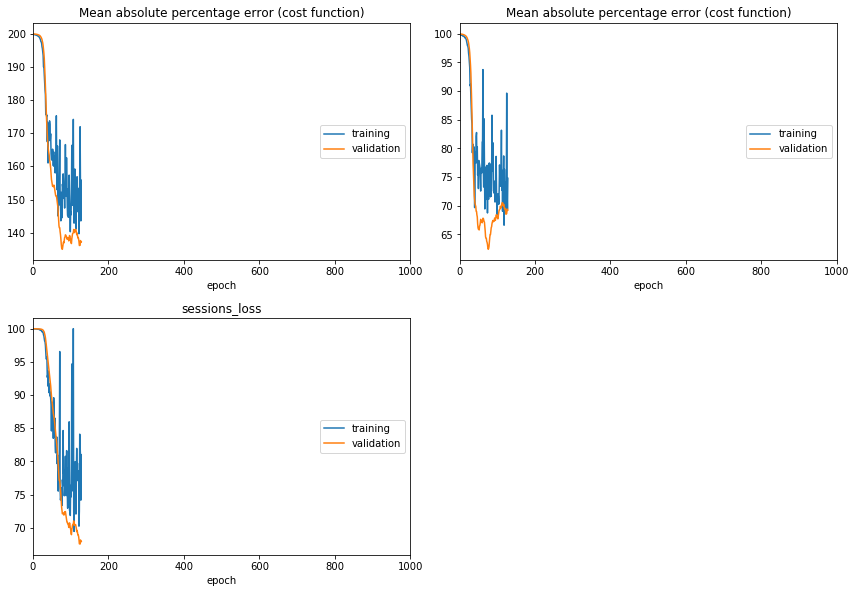

335/335 [==============================] - 1s 2ms/step - loss: 155.8291 - clients_loss: 74.7991 - sessions_loss: 81.0300 - val_loss: 137.2113 - val_clients_loss: 69.2545 - val_sessions_loss: 67.9568
Epoch 00128: early stopping


In [8]:
clear_session()

epochs = 1000
reg = None # l1_l2(0.01,0.02)

stack_layers = lambda layers: reduce(lambda stack, e: e(stack), layers)

weather_layers = \
  [Input((3,), name='weather')] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)]

weather_out = stack_layers(weather_layers)

day_layers = \
  [Input((7,), name='day')] \
+ [Dense(15, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(25, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(12, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)]

day_out = stack_layers(day_layers)

date_layers = \
  [Input((1,), name='date')] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(50, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(15, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)]

date_out = stack_layers(date_layers)

main_layers = \
  [concatenate([weather_out, day_out, date_out])] \
+ [Dense(50, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(100, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(100, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(50, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] 

main_out = stack_layers(main_layers)

"""
usage_layers = \
  [main_out] \
+ [Dense(80, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(40, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(7, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(4, activation='relu',kernel_regularizer=reg, name='usage')]

usage_out=stack_layers(usage_layers)
"""

clients_layers = \
  [main_out] \
+ [Dense(30, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(1, activation='relu',kernel_regularizer=reg, name='clients')]

clients_out = stack_layers(clients_layers)

sessions_layers = \
  [main_out] \
+ [Dense(30, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(30, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(1, activation='relu',kernel_regularizer=reg, name='sessions')]

sessions_out = stack_layers(sessions_layers)

model = Model(inputs=[weather_layers[0], day_layers[0], date_layers[0]], outputs=[clients_out,sessions_out])
model.compile(loss='mean_absolute_percentage_error',
              optimizer=Adam(0.0001))

model.summary()

early_stopping = EarlyStopping(patience=50, verbose=1)
history = model.fit(x=[weather_x,day_x,date_x], y=[clients_y,sessions_y],
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_data,
                    callbacks=[early_stopping, PlotLossesKeras()],
                    batch_size=32)
model_path = join('..','models','model.h5')
model.save(model_path)


In [7]:
sessions_y

array([[ 988.        ],
       [1103.        ],
       [1008.        ],
       [ 796.        ],
       [ 814.        ],
       [1163.        ],
       [1870.        ],
       [1065.        ],
       [ 633.        ],
       [ 676.        ],
       [ 824.        ],
       [ 974.        ],
       [ 840.        ],
       [2000.        ],
       [1470.        ],
       [1014.        ],
       [ 824.        ],
       [1447.        ],
       [1014.        ],
       [1084.        ],
       [1162.        ],
       [1239.        ],
       [ 916.        ],
       [1412.        ],
       [1270.        ],
       [1167.        ],
       [ 635.        ],
       [ 959.        ],
       [1565.        ],
       [1300.        ],
       [1271.        ],
       [ 875.        ],
       [2098.        ],
       [1443.        ],
       [ 931.        ],
       [ 577.        ],
       [1098.        ],
       [1247.        ],
       [1298.        ],
       [1596.        ],
       [2175.        ],
       [1268.   